In [61]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [62]:
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 32

LOAD_MODEL = False
model_path = "models/Xception_2015_ben_color_3_epochs_70_fine_tune_2"
base_model = tf.keras.applications.Xception(
    input_shape=INPUT_SHAPE, include_top=False, weights="imagenet"
)

In [63]:
def create_data(DATA):
    datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        # width_shift_range=0.2,
        # height_shift_range=0.2,
        # shear_range=0.2,
        validation_split=0.10,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=20,
    )

    train_generator = datagen.flow_from_directory(
        DATA,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        subset="training",
    )

    val_generator = datagen.flow_from_directory(
        DATA,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        subset="validation",
    )

    return train_generator, val_generator

In [64]:
class ModelCNN:
    def __init__(self):
        self.input_shape = INPUT_SHAPE
        self.base_model = base_model
        self.base_model.trainable = False
        self.optimizer = tf.keras.optimizers.Adam
        self.loss = "MSE"
        self.metrics = ["accuracy"]
        self.model = self.create_model()
        self.losses = []
        self.accuracies = []
        self.val_losses = []
        self.val_accuracies = []

    def create_model(self):
        DROPOUT_RATE = 0.25
        model = tf.keras.Sequential(
            [
                self.base_model,
                layers.GlobalAveragePooling2D(),
                layers.Dropout(DROPOUT_RATE),
                layers.Dense(128, activation="relu"),
                layers.Dropout(DROPOUT_RATE),
                layers.Dense(5, activation="softmax"),
            ]
        )

        # print(model.summary())
        return model

    def train(self, train_data, valid_data, epochs, learning_rate):
        self.base_model.trainable = False
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.model.compile(
            optimizer=self.optimizer(learning_rate=learning_rate),
            loss=self.loss,
            metrics=self.metrics,
        )
        history = self.model.fit(
            train_data,
            epochs=self.epochs,
            validation_data=valid_data,
        )
        self.losses.extend(history.history["loss"])
        self.accuracies.extend(history.history["accuracy"])
        self.val_losses.extend(history.history["val_loss"])
        self.val_accuracies.extend(history.history["val_accuracy"])
        return self.get_best_results()

    def fine_tune(self, train_data, valid_data, fine_tune_at):
        self.base_model.trainable = True
        for layer in self.base_model.layers[:fine_tune_at]:
            layer.trainable = False

        self.model.compile(
            optimizer=self.optimizer(learning_rate=self.learning_rate / 10),
            loss=self.loss,
            metrics=self.metrics,
        )
        history = self.model.fit(
            train_data,
            epochs=self.epochs * 2,
            initial_epoch=self.epochs,
            validation_data=valid_data,
        )
        self.losses.extend(history.history["loss"])
        self.accuracies.extend(history.history["accuracy"])
        self.val_losses.extend(history.history["val_loss"])
        self.val_accuracies.extend(history.history["val_accuracy"])

        return self.get_best_results()

    def plot_history(self):
        plt.figure(figsize=(8, 8))
        plt.subplot(2, 1, 1)
        plt.plot(self.losses, label="Training Loss")
        plt.plot(self.val_losses, label="Validation Loss")
        plt.plot([self.epochs, self.epochs], plt.ylim(), label="Start Fine Tuning")
        plt.legend(loc="upper right")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")

        plt.subplot(2, 1, 2)
        plt.plot(self.accuracies, label="Training Accuracy")
        plt.plot(self.val_accuracies, label="Validation Accuracy")
        plt.plot([self.epochs, self.epochs], plt.ylim(), label="Start Fine Tuning")
        plt.legend(loc="lower right")
        plt.ylabel("Accuracy")
        plt.title("Training and Validation Accuracy")
        plt.xlabel("epoch")
        plt.show()

    def save_model(self, path):
        self.model.save(path)

    def load_model(self, path):
        self.model = tf.keras.models.load_model(path)
        return self.model

    def get_best_results(self):
        best_epoch = np.argmax(np.array(self.val_accuracies))
        best_val_accuracy = self.val_accuracies[best_epoch]
        best_val_loss = self.val_losses[best_epoch]
        train_loss = self.losses[best_epoch]
        train_accuracy = self.accuracies[best_epoch]
        return best_epoch, best_val_accuracy, best_val_loss, train_accuracy, train_loss

In [65]:
LR = 0.0001
EPOCHS = 5
fine_tune_at = 70

In [66]:
# DATA = "Data/Gaussian_filtered/gaussian_filtered_images"
# DATA = 'Data/Resized/preprocessed_3'
# DATA = 'Data/Resized/colored_images'
# DATA = 'Data/Resized/organized_2015'
# DATA = 'Data/Resized/preprocessed_2015'
DATA = "Data/Resized/preprocessed_2015_ben_color"

train_data, val_data = create_data(DATA)
CNN = ModelCNN()
if LOAD_MODEL:
    CNN.load_model(model_path)

Found 31600 images belonging to 5 classes.
Found 3508 images belonging to 5 classes.


Epoch 1/5
988/988 [==============================] - 215s 216ms/step - loss: 0.0849 - accuracy: 0.7337 - val_loss: 0.0802 - val_accuracy: 0.7352
Epoch 2/5
988/988 [==============================] - 213s 215ms/step - loss: 0.0821 - accuracy: 0.7363 - val_loss: 0.0809 - val_accuracy: 0.7429
Epoch 3/5
988/988 [==============================] - 213s 215ms/step - loss: 0.0814 - accuracy: 0.7379 - val_loss: 0.0786 - val_accuracy: 0.7383
Epoch 4/5
988/988 [==============================] - 213s 215ms/step - loss: 0.0808 - accuracy: 0.7394 - val_loss: 0.0781 - val_accuracy: 0.7412
Epoch 5/5
988/988 [==============================] - 213s 216ms/step - loss: 0.0804 - accuracy: 0.7412 - val_loss: 0.0790 - val_accuracy: 0.7409
Epoch 6/10
988/988 [==============================] - 220s 221ms/step - loss: 0.0810 - accuracy: 0.7389 - val_loss: 0.0763 - val_accuracy: 0.7469
Epoch 7/10
988/988 [==============================] - 219s 221ms/step - loss: 0.0770 - accuracy: 0.7490 - val_loss: 0.0741 - val_

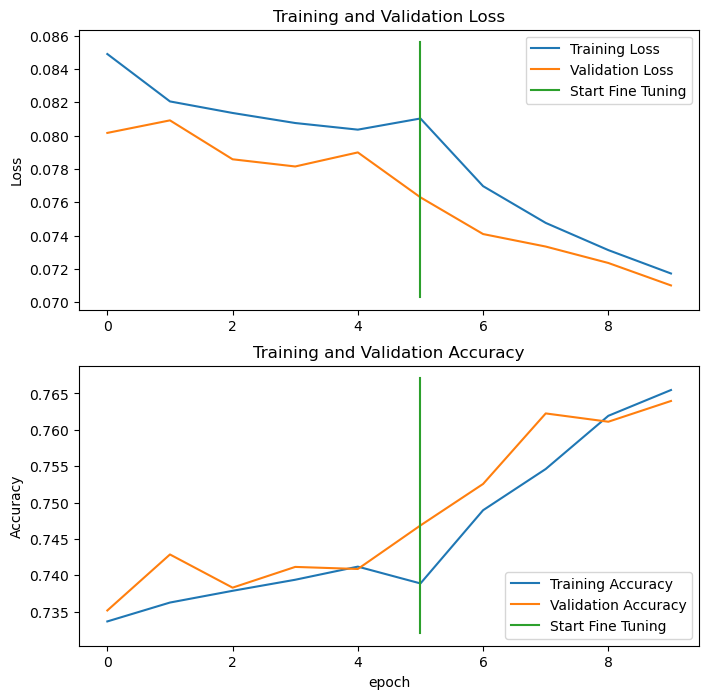

INFO:tensorflow:Assets written to: models/Xception_2015_ben_color_3_epochs_70_fine_tune_2\assets
(9, 0.7639680504798889, 0.0710078775882721, 0.7654746770858765, 0.07172399759292603)


In [67]:
if not LOAD_MODEL:
    with tf.device("/GPU:0"):
        CNN.train(train_data, val_data, epochs=EPOCHS, learning_rate=LR)
        CNN.fine_tune(train_data, val_data, fine_tune_at=fine_tune_at)
    CNN.plot_history()
    CNN.save_model(model_path)
    print(CNN.get_best_results())
else:
    print("DONE")

In [68]:
""" DATA = 'Data/Resized/preprocessed_2019_ben_color'
train_data, val_data = create_data(DATA)

with tf.device("/GPU:0"):
    CNN.train(train_data, val_data, epochs=20, learning_rate=LR)
    CNN.fine_tune(train_data, val_data, fine_tune_at=70)
CNN.plot_history() """

' DATA = \'Data/Resized/preprocessed_2019_ben_color\'\ntrain_data, val_data = create_data(DATA)\n\nwith tf.device("/GPU:0"):\n    CNN.train(train_data, val_data, epochs=20, learning_rate=LR)\n    CNN.fine_tune(train_data, val_data, fine_tune_at=70)\nCNN.plot_history() '

In [69]:
# evaluate model with validation data
res = CNN.model.evaluate(val_data)
print(res)

110/110 [==============================] - 24s 217ms/step - loss: 0.0718 - accuracy: 0.7643
[0.07182403653860092, 0.7642531394958496]


In [70]:
# call model with val data and get predictions
predictions = CNN.model.predict(val_data)

In [71]:
print(predictions)
print(np.sum(predictions, axis=1).tolist())

[[4.79317717e-02 2.24586427e-01 7.16146827e-01 6.28743228e-03
  5.04761701e-03]
 [3.54808085e-02 4.22948264e-02 9.21325028e-01 2.53332837e-04
  6.46000612e-04]
 [1.53912202e-01 7.77473524e-02 7.52265275e-01 6.03104848e-03
  1.00441258e-02]
 ...
 [1.33145884e-01 1.80773914e-01 6.63020134e-01 9.30779614e-03
  1.37523245e-02]
 [7.86849707e-02 3.00896406e-01 5.97745597e-01 3.88292572e-03
  1.87900383e-02]
 [5.30155338e-02 1.79113105e-01 7.51382649e-01 5.68936719e-03
  1.07994461e-02]]
[1.0, 1.0, 1.0, 1.0000001192092896, 1.0, 1.0, 1.0, 1.0000001192092896, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0000001192092896, 1.0, 1.0, 0.9999999403953552, 0.9999999403953552, 1.0, 1.0000001192092896, 1.0, 0.9999999403953552, 1.0, 1.0, 0.9999998807907104, 0.9999999403953552, 1.0, 1.0, 1.0, 0.9999999403953552, 0.9999998807907104, 1.0, 1.0, 0.9999999403953552, 0.9999999403953552, 0.9999999403953552, 1.0, 1.0000001192092896, 1.0000001192092896, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999403953552, 0.9999998807907104

In [72]:
print(predictions.shape)
# print tensor with predictions
# print(predictions)
# print(np.argmax(predictions, axis=1).tolist())
pred = np.argmax(predictions, axis=1).tolist()

pred_ammount = pred.count(0), pred.count(1), pred.count(2), pred.count(3), pred.count(4)
print(pred_ammount)

# get true labels
true_labels = val_data.classes.tolist()
true_ammount = (
    true_labels.count(0),
    true_labels.count(1),
    true_labels.count(2),
    true_labels.count(3),
    true_labels.count(4),
)
print(true_ammount)

(3508, 5)
(0, 240, 3161, 71, 36)
(243, 528, 2580, 70, 87)


In [73]:
# Show confusion matrix

import numpy as np

y_pred = np.argmax(predictions, axis=1)
y_true = val_data.classes
print(y_pred.tolist())
print(y_true.tolist())
confusion_mtx = confusion_matrix(y_true, y_pred)

confusion_mtx

[2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 

array([[   0,   25,  213,    4,    1],
       [   0,   38,  475,   11,    4],
       [   0,  167, 2335,   52,   26],
       [   0,    6,   58,    3,    3],
       [   0,    4,   80,    1,    2]], dtype=int64)

<Axes: title={'center': 'Confusion Matrix'}>

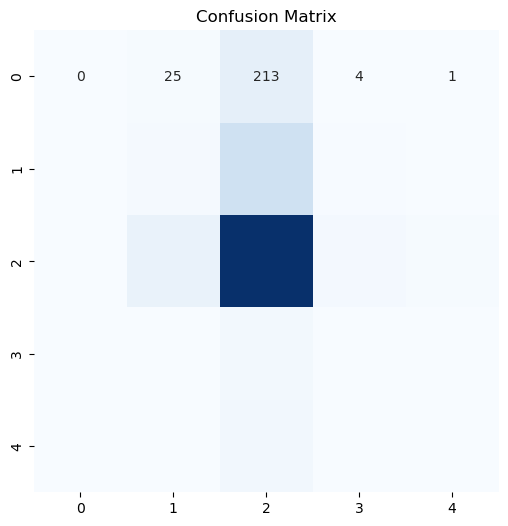

In [74]:
plt.figure(figsize=(6, 6))
plt.title("Confusion Matrix")
# using matplot lib to show the confusion matrix
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues", cbar=False)

In [75]:
c = 0
for pred, true in zip(y_pred, y_true):
    if pred == true:
        c += 1
print(c, 1.0 * c / len(y_pred))
print(len(y_pred))

2378 0.67787913340935
3508


In [76]:
# Print MSE between y_pred and y_true
print(np.mean((y_pred - y_true) ** 2))

0.6411060433295325
